In [5]:
#Imports
import numpy as np
import pandas as pd

from scipy.stats import skew
from scipy.stats.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#from jupyterthemes import jtplot
#jtplot.style('onedork')
#jtplot.style(ticks=True, grid=True)
matplotlib.rc('font', size=20)
matplotlib.rc('axes', titlesize=20)
matplotlib.rc('axes', labelsize=20)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('legend', fontsize=20)
matplotlib.rc('figure', titlesize=20)
#jtplot.reset()
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, LassoLarsCV, ElasticNet, Lasso
from sklearn.cross_validation import cross_val_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [6]:
#importing data
train_DF = pd.read_csv('train.csv')

test_DF = pd.read_csv('test.csv')
train_DF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print("------Training Data Information-------\n")
train_DF.info()
print("\n\n------Test Data Information-------\n")
test_DF.info()
concat = pd.concat((train_DF.loc[:,'MSSubClass':'SaleCondition']
                      ,test_DF.loc[:,'MSSubClass':'SaleCondition'])) #Avoid Categorical differences ahead

------Training Data Information-------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non

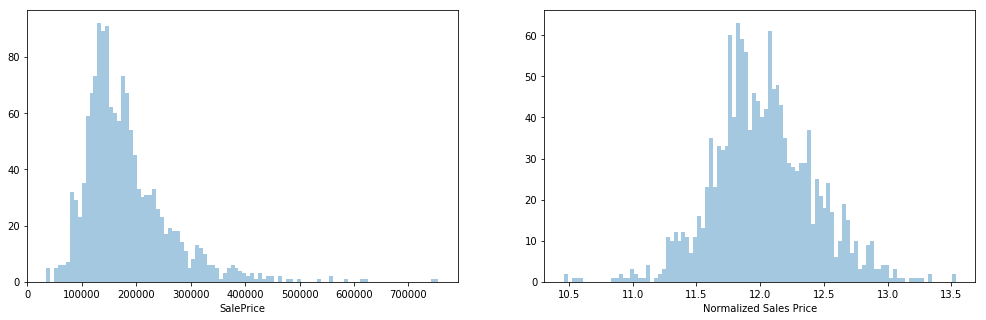

In [5]:
#Plot a general distribution of the prices (Fixing the skewed meytSkewed Metric)
figure, (ax1, ax2) = plt.subplots(1,2,figsize = (17,5))
sns.distplot(train_DF['SalePrice'], kde = False, ax = ax1, bins = 100)
sns.distplot(np.log1p(train_DF["SalePrice"]), kde = False, axlabel = 'Normalized Sales Price', ax = ax2, bins = 100)
train_DF['SalePrice'] = np.log1p(train_DF["SalePrice"])

In [6]:
#fixing other numeric skewed metrics
numeric_features_train = concat.dtypes[train_DF.dtypes != 'object'].index

skewed_features_train = concat[numeric_features_train].apply(lambda x: skew(x.dropna()))

skewed_features_train = skewed_features_train[skewed_features_train > 0.75]
skewed_features_train = skewed_features_train.index

concat[skewed_features_train] = np.log1p(concat[skewed_features_train])

In [7]:
concat.head() #Always a good practise to keep a check on the operating dataframe every once in while

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,4.110874,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal
1,3.044522,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal
2,4.110874,RL,4.234107,9.328212,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal
3,4.262680,RL,4.110874,9.164401,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml
4,4.110874,RL,4.442651,9.565284,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal


In [8]:
#Getting dummies for all the non numeric data
concat = pd.get_dummies(concat)
#Fill in empty values with mean of each column
concat = concat.fillna(train_DF.mean())

In [9]:
#Classifying training and test data
X = concat[:train_DF.shape[0]]
X_test = concat[train_DF.shape[0]:]
Y = train_DF.SalePrice
X.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0


In [10]:
#Define function for determining Tuning Parameter
def cv_error(model):
    cve= np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv = 5))
    return(cve)
X_test.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3.044522,4.394449,9.360741,5,6,1961,1961,0.000000,6.150603,4.976734,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.406719,9.565775,6,6,1958,1958,4.691348,6.828712,0.000000,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.317488,9.534668,5,5,1997,1998,0.000000,6.674561,0.000000,...,0,0,0,1,0,0,0,0,1,0


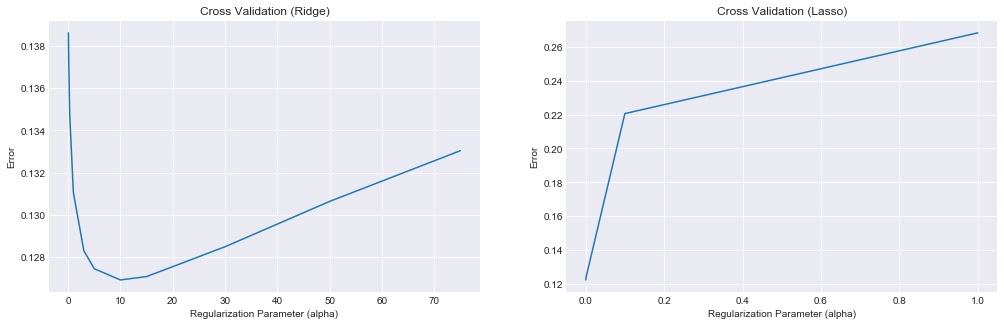

In [31]:
#Ridge
a_ridge = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cvScores_ridge = [cv_error(Ridge(alpha = alpha)).mean() for alpha in a_ridge]
cvScores_ridge = pd.Series(cvScores_ridge, index = a_ridge)
minimum_error = cvScores_ridge.min()

#Lasso
a_lasso = [1, 0.1, 0.001, 0.0005]
cvScores_lasso = [cv_error(Lasso(alpha = alpha)).mean() for alpha in a_lasso]
cvScores_lasso = pd.Series(cvScores_lasso, index = a_lasso)
minimum_error_lasso = cvScores_lasso.min()

#Plots
figure, (ax1, ax2) = plt.subplots(1,2,figsize = (17,5))
ax1.plot(cvScores_ridge)
ax1.set_title("Cross Validation (Ridge)")
ax1.set_xlabel("Regularization Parameter (alpha)")
ax1.set_ylabel("Error")
ax2.plot(cvScores_lasso)
ax2.set_title("Cross Validation (Lasso)")
ax2.set_xlabel("Regularization Parameter (alpha)")
ax2.set_ylabel("Error")

In [20]:
print("Minimum Error for Ridge Model: ", minimum_error)
print("Minimum Error for Lasso Model: ", minimum_error_lasso)

Minimum Error for Ridge Model:  0.126915218001
Minimum Error for Lasso Model:  0.122423391373


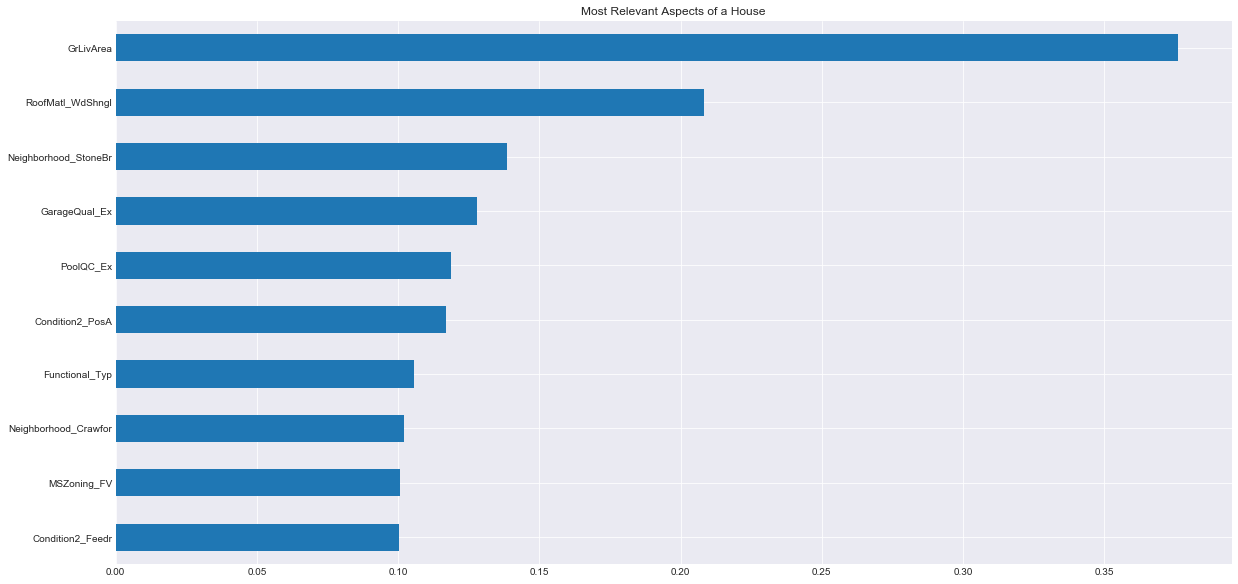

In [21]:
#Picking up Ridge Model & figuring 10 most useful and 10 least useful parameters for Housing Price Prediction
ridgeReg = Ridge()
ridgeReg.fit(X,Y)
coef = pd.Series(ridgeReg.coef_, index = X.columns)
relevant_Coeff = coef.sort_values().tail(10)
irrelevant_Coeff = coef.sort_values().head(10)

#Plots
plt.figure(figsize=(20,10))
relevant_Coeff.plot(kind = "barh", title="Most Relevant Aspects of a House")

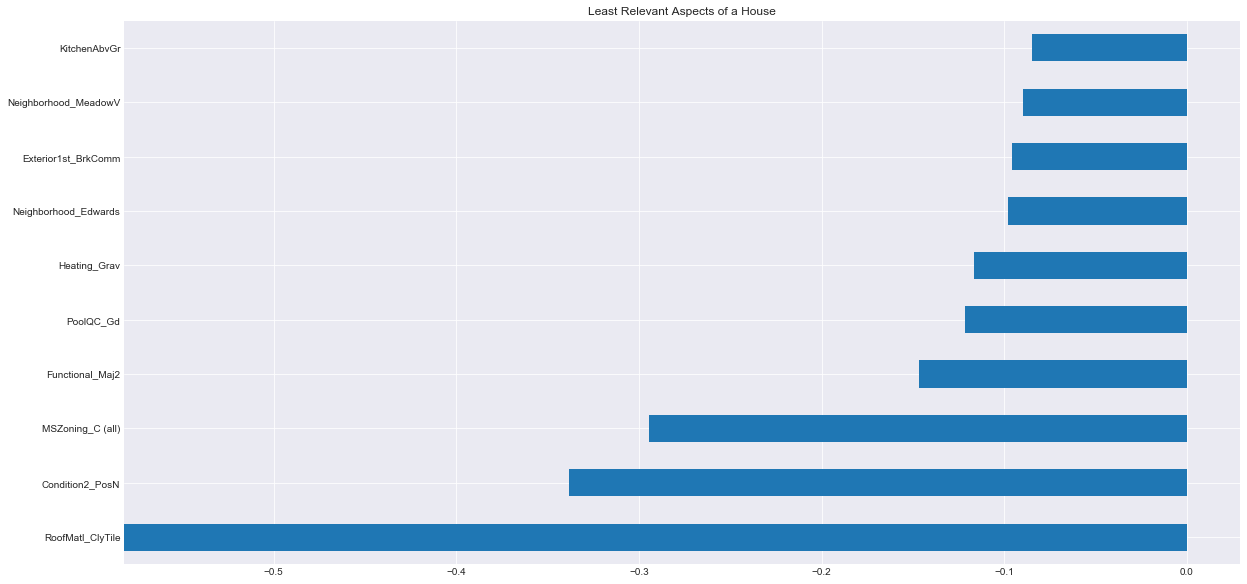

In [22]:
plt.figure(figsize=(20,10))
irrelevant_Coeff.plot(kind = 'barh', title="Least Relevant Aspects of a House")

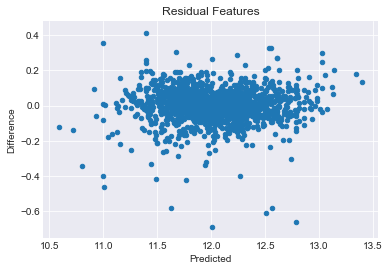

In [23]:
#Remaining Feature Set
plt.figure(figsize= (50,10))
preds = pd.DataFrame({"Predicted":ridgeReg.predict(X), "true":Y})
preds["Difference"] = preds["true"] - preds["Predicted"]
preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features")

In [24]:
ridgeReg.score(X,Y)

0.94257351355581265

In [25]:
#94.25% Accuracy Achieved
train_DF.info()
test_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [26]:
preds = np.expm1(ridgeReg.predict(X_test)) #Exponential function used to balance out log(x + 1) 
solution = pd.DataFrame({"id":test_DF.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

In [27]:
rg = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=3)

In [28]:
rg.fit(X,Y)
rg.score(X,Y)

0.98072335233861141

In [29]:
preds = np.expm1(rg.predict(X_test)) #Exponential function used to balance out log(x + 1) 
solution = pd.DataFrame({"id":test_DF.Id, "SalePrice":preds})
solution.to_csv("submission.csv", index = False)

In [14]:
train_DF.isnull().mean().sort_values(ascending=False)

PoolQC           0.995205
MiscFeature      0.963014
Alley            0.937671
Fence            0.807534
FireplaceQu      0.472603
LotFrontage      0.177397
GarageCond       0.055479
GarageType       0.055479
GarageYrBlt      0.055479
GarageFinish     0.055479
GarageQual       0.055479
BsmtExposure     0.026027
BsmtFinType2     0.026027
BsmtFinType1     0.025342
BsmtCond         0.025342
BsmtQual         0.025342
MasVnrArea       0.005479
MasVnrType       0.005479
Electrical       0.000685
Utilities        0.000000
YearRemodAdd     0.000000
MSSubClass       0.000000
Foundation       0.000000
ExterCond        0.000000
ExterQual        0.000000
Exterior2nd      0.000000
Exterior1st      0.000000
RoofMatl         0.000000
RoofStyle        0.000000
YearBuilt        0.000000
                   ...   
GarageArea       0.000000
PavedDrive       0.000000
WoodDeckSF       0.000000
OpenPorchSF      0.000000
3SsnPorch        0.000000
BsmtUnfSF        0.000000
ScreenPorch      0.000000
PoolArea    

In [15]:
train = train_DF.drop(['PoolQC','MiscFeature','Alley','Fence'], axis=1)

In [32]:
train.columns.get_indexer(train.select_dtypes('object').columns)

array([ 2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24,
       26, 27, 28, 29, 30, 31, 32, 34, 38, 39, 40, 41, 52, 54, 56, 57, 59,
       62, 63, 64, 74, 75])